# Szukamy lepszego modelu
Poniższy notebook to moje podejście do ćwiczenia projektowego tzn. testowania innych modeli na zadaniu cats vs dogs. Wprowadziłem do oryginalnego modelu sporo zmian, aby w efekcie osiągnąć poprawność rzędu 90% na danych testowych (poprawność jest gdzieś między 91% a 92% dla ostatnich kroków treningu).  
Od Waszych projektów nie oczekuję oczywiście takiego zaangażowania. :)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten,
                          BatchNormalization, Dropout)
%matplotlib inline

from emosie import load_images


# wczytujemy listę nazw plików z folderu `img_dir`
img_dir = r'psy_vs_koty/train'
images = os.listdir(img_dir)
full_images = [os.path.join(img_dir, img) for img in images]

print('Znaleziono {} obrazów.'.format(len(images)))

Znaleziono 25000 obrazów.


In [2]:
# wczytujemy dane
X, y = load_images(img_dir, n_images=25000, resize=(80, 80))

# dzielimy przez 255 aby wartości pikseli mieściły się w ramach 0 - 1
X /= 255.

# dzielimy na dane testowe i treningowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=23)

# usuwamy oryginalne, niepodzielone dane (aby oszczędzić pamięć komputera)
del X, y

**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
*******************************

In [11]:
# zapisuję dane na dysku (aby móc je później szybko wczytywać w razie restartu notebook'a)
np.save('X_train_80_80.npy', X_train)
np.save('X_test_80_80.npy', X_test)
np.save('y_train_80_80.npy', y_train)
np.save('y_test_80_80.npy', y_test)

In [3]:
# wczytuję z dysku (teraz wczytywanie trwa ok. 2-3 s
# w porównaniu do kilkunastu sekund dla `load_images`)
X_train = np.load('X_train_80_80.npy')
X_test  = np.load('X_test_80_80.npy')
y_train = np.load('y_train_80_80.npy')
y_test  = np.load('y_test_80_80.npy')

# Bardziej złożony model

Tworzę poniżej bardziej złożony model niż te, z których korzystaliście dotychczas na zajęciach.

Piszę poniżej o *efektach splotu* / *efektach filtra* - chodzi o cały efekt splecienia danego filtra z aktywnością poprzedzającej warstwy sieci. Aktywność przed i po każdej warstwie splotowej ma zawsze wymiary (wysokość, szerokość, filtry), gdzie dla danych wejściowych filtry do warstwy kolorystyczne R G i B obrazu. Po pierwszej warstwie splotowej mamy w aktywności wyjściowej do czynienia z obrazami będącymi efektem splotu filtra z oryginalnym obrazem. Np. pierwsza warstwa splotowa daje output `64 x 64 x 16` co znaczy: 16 filtrów daje 16 efektów splotu, każdy ma rozmiary `64 x 64`. Warto jednak pamiętać, że po zastosowaniu watswy `MaxPooling` z opcją `pool_size=(2, 2)` redukujemy każdy efekt splotu dwukrotnie, a więc mamy już aktywność wielkości: `32 x 32 x 16`.

Podstawowe zmiany względem sieci z notebook'a 6:
* korzystamy ze wszystkich zdjęć treningowych (`25 000`), 5% (`1250`) poświęcamy na dane testowe, 4% z pozostałych danych treningowych (`1188`) wykorzystujemy do walidacji
* jedna warstwa splotowa więcej (wcześniej były chyba 3, teraz są 4)
* `MaxPooling` jest po każdej warstwie splotowej, a więc dokonujemy większej redukcji rozmiaru
* ale z kolei obrazy wejściowe mają teraz rozmiar `80 x 80`, a więc są prawie dwa razy większe
* zamiast aktywacji typu `relu` korzystam z `elu` - to trochę bardziej złożona funkcja aktywacyjna, wyglądająca tak (niebieska linia):
<img src="https://raw.githubusercontent.com/aleju/papers/master/neural-nets/images/ELUs__slopes.png">
  Co najmniej jeden artykuł sugeruje, że tego rodzaju aktywacja prowadzi do szybszego treningu.
* z każdą kolejną warstwą rośnie liczba używanych filtrów (`16 -> 32 -> 64 -> 128`). To dosyć standardowe zagranie w literaturze CNN, szczególnie gdy z każdą kolejną warstwą splotową redukujemy rozmiar pod kątem wysokości i szerokości przez `MaxPooling`. Przy tak dużej liczbie filtrów mamy też dużo więcej parametrów do nauki, co może prowadzić do overfittingu, w związku z czym:
* `Dropout` jest dodawany po każdej warstwie splotowej, przy czym dropout występuje na całych filtrach, a nie na pojedynczych wartościach (tzn. wypada cały jeden efekt splotu na raz, nie może wypaść tylko kilka wartości z jednego efektu danego filtra). Tego rodzaju dropout ma większy sens dla warstw splotowych - zmusza sieć do tego aby nie polegała tylko na pojedynczych filtrach, ale starała się utworzyć filtry tak, aby każdy dawał wartościowe informacje
* po rozprostowaniu ostatniej warstwy splotowej o rozmiarach `3 x 3 x 128` łaczymy ją z warstwą `Dense` o rozmiarze 128 - tzn. mamy więcej neuronów w klasyfikacyjnej części sieci

Poniżej przykładowo zmiany rozmiarów warstw z kolejnymi operacjami:

input: `80 x 80 x 3`

warstwa | `Conv2d` | `MaxPooling`
---|---|---
1 | `78 x 78 x 16` | `39 x 39 x 16`
2 | `37 x 37 x 32` | `18 x 18 x 32`
3 | `16 x 16 x 64` | `8 x 8 x 64`
4 | `6 x 6 x 128`  | `3 x 3 x 128`


In [4]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(80, 80, 3), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.35, noise_shape=(None, 1, 1, 32)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.35, noise_shape=(None, 1, 1, 64)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5, noise_shape=(None, 1, 1, 128)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

## Wiele kroków treningu sieci
Ta część byłaby nudna, ale wzbogaciłem ją w komentarze. :)

Najpierw kompilujemy model aby przygotować go do treningu.

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Ustawiamy trening na 35 epok, przy czym przerywamy trening przy braku poprawy dla danych walidacyjnych przez 5 epok. Dane walidacyjne to 5% losowo wybranych obrazów z danych treningowych.

In [6]:
stop_early = EarlyStopping(patience=5)
history = model.fit(X_train, y_train, epochs=35, validation_split=0.05, callbacks=[stop_early])

Train on 22562 samples, validate on 1188 samples
Epoch 1/35
22562/22562 [==============================] - 756s 34ms/step - loss: 0.7724 - acc: 0.5932 - val_loss: 0.5954 - val_acc: 0.7062
Epoch 2/35
22562/22562 [==============================] - 729s 32ms/step - loss: 0.5959 - acc: 0.6745 - val_loss: 0.5487 - val_acc: 0.7020
Epoch 3/35
22562/22562 [==============================] - 730s 32ms/step - loss: 0.5540 - acc: 0.7125 - val_loss: 0.5232 - val_acc: 0.7130
Epoch 4/35
22562/22562 [==============================] - 742s 33ms/step - loss: 0.5301 - acc: 0.7325 - val_loss: 0.4955 - val_acc: 0.7542
Epoch 5/35
22562/22562 [==============================] - 736s 33ms/step - loss: 0.5093 - acc: 0.7510 - val_loss: 0.5053 - val_acc: 0.7424
Epoch 6/35
22562/22562 [==============================] - 740s 33ms/step - loss: 0.4879 - acc: 0.7626 - val_loss: 0.4158 - val_acc: 0.8039
Epoch 7/35
22562/22562 [==============================] - 734s 33ms/step - loss: 0.4681 - acc: 0.7781 - val_loss: 0.4

Chociaż model jest mocno obwarowany dropout'em obserwujemy poprawność rzędu 70% już przy trzeciej epoce. Validation accurracy dla trzeciej epoki to z kolei 71%, a więc poprawność na danych treningowych i walidacyjnych na poczatku idzie łeb w łeb. Poprawność na danych treningowych jest niższa, bo model doświadcza dropout'u, a więc gubi część swoich neuronów. Podczas testowania na danych walidacyjnych nie używamy już jednak dropout'u - w efekcie poprawność jest wyższa na danych walidacyjnych.
    W kolejnych epokach poprawność rośnie już wolniej, ale sukcesywnie wraz ze wzrostem poprawności na danych treningowych widzimy wzrost poprawności na danych walidacyjnych - tym razem poprawnosć ta przekracza 80% (6 epoka), następnie 85% (11 epoka), 88% (16 epoka) i wreszcie ociera się o 90% (89%) by niestety spaść wreszcie do 81%.  
Stwierdziłem, że będę kontynuował trening mimo braku poprawy przez ostatnie 5 epok, poprawność fluktuuje w ostatnich epokach wciąż w okolicach 88%, a spadek do 81% jest raczej tymczasowy, liczę na to, że model 'dojedzie' do 90%:

In [9]:
history_next = model.fit(X_train, y_train, epochs=35, validation_split=0.05, callbacks=[stop_early])

Train on 22562 samples, validate on 1188 samples
Epoch 1/35
22562/22562 [==============================] - 1085s 48ms/step - loss: 0.2785 - acc: 0.8829 - val_loss: 0.2359 - val_acc: 0.9133
Epoch 2/35
22562/22562 [==============================] - 1086s 48ms/step - loss: 0.2743 - acc: 0.8837 - val_loss: 0.2521 - val_acc: 0.8914
Epoch 3/35
22562/22562 [==============================] - 996s 44ms/step - loss: 0.2754 - acc: 0.8828 - val_loss: 0.2403 - val_acc: 0.9066
Epoch 4/35
22562/22562 [==============================] - 692s 31ms/step - loss: 0.2703 - acc: 0.8845 - val_loss: 0.2414 - val_acc: 0.9125
Epoch 5/35
22562/22562 [==============================] - 732s 32ms/step - loss: 0.2605 - acc: 0.8895 - val_loss: 0.2540 - val_acc: 0.9133
Epoch 6/35
22562/22562 [==============================] - 754s 33ms/step - loss: 0.2618 - acc: 0.8900 - val_loss: 0.2572 - val_acc: 0.8981


Teraz już w pierwszej epoce mamy ponad 90%, ale warto pamiętać, że nie musi to być faktyczna poprawa - do danych walidacyjnych mogły trafić teraz inne bodźce (np. te na których wcześniej sieć się uczyła). Z tego względu czasem warto własnoręcznie wydzielać dane walidacyjne (tak samo jak testowe). Widzimy jednak, że trening niewiele już poprawia, zatrzymam się w związku z tym na takim poziomie wytrenowania, chociaż możnaby próbować jeszcze dalej. Zobaczmy najpierw historię pierwszego treningu:

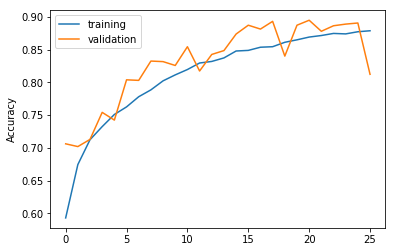

In [11]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.ylabel('Accuracy')
plt.legend()

Poprawność na danych walidacyjnych bardzo ładnie rośnie wraz z poprawnością na danych treningowych (chociaż jest obarczona większym szumem). Jest to w dużej mierze zasługa regularyzacji (`Dropout` ale jak regularyzacja działa też `BatchNormalization`). Po pierwsze regularyzacja sprawia, że mimo iż trenujemy zdecydowanie bardziej złożony model (liczba parametrów: XXX), jesteśmy bardziej odporni na *overfitting* czyli wyuczanie się charakterystyki setu treningowego, be uczenia się wzorców umożliwiających generalizację. Po drugie poprawność na danych treningowych będzie niższa ze względu na stosowany dropout, którego nie ma podczas sprawdzania poprawności na datasecie walidacyjnym.   
Zobaczmy jak wygląda kontynuacja treningu (gdzie niestety do walidacji mogły trafić inne zdjęcia):

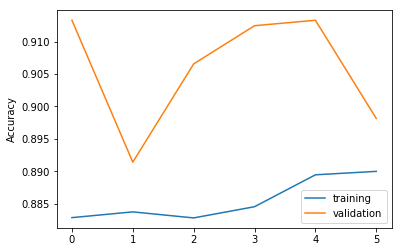

In [13]:
plt.plot(history_next.history['acc'], label='training')
plt.plot(history_next.history['val_acc'], label='validation')
plt.ylabel('Accuracy')
plt.legend()

Myślę że tego rodzaju wykres sugeruje, że jest jeszcze miejsce na trening, zmienność w poprawności na danych walidacyjnych jest duża. Sprawdźmy jednak jaką poprawność ma model na danych testowych:

In [10]:
model.evaluate(X_test, y_test)

1250/1250 [==============================] - 15s 12ms/step


[0.2622698540687561, 0.8856]

Output tej komórki to lista `[loss, accurracy]` tzn. pierwsza wartość to funkcja kosztu, a druga to poprawność.  
`88%` to całkiem nieźle, dużo lepiej niż model, który znacie z zajęć. Prawdopodobnie przy dłuższym treningu poprawność doszłaby do 90%, może nawet trochę więcej. Sprawdźmy jeszcze 10 epok treningowych używając za zbiór walidacyjny dane testowe.

In [15]:
history_last = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 23750 samples, validate on 1250 samples
Epoch 1/10
23750/23750 [==============================] - 789s 33ms/step - loss: 0.2692 - acc: 0.8863 - val_loss: 0.2559 - val_acc: 0.8856
Epoch 2/10
23750/23750 [==============================] - 797s 34ms/step - loss: 0.2562 - acc: 0.8915 - val_loss: 0.2626 - val_acc: 0.8912
Epoch 3/10
23750/23750 [==============================] - 794s 33ms/step - loss: 0.2588 - acc: 0.8920 - val_loss: 0.2544 - val_acc: 0.8944
Epoch 4/10
23750/23750 [==============================] - 769s 32ms/step - loss: 0.2524 - acc: 0.8939 - val_loss: 0.2373 - val_acc: 0.9064
Epoch 5/10
23750/23750 [==============================] - 772s 33ms/step - loss: 0.2517 - acc: 0.8928 - val_loss: 0.2577 - val_acc: 0.8912
Epoch 6/10
23750/23750 [==============================] - 792s 33ms/step - loss: 0.2492 - acc: 0.8942 - val_loss: 0.2594 - val_acc: 0.8880
Epoch 7/10
23750/23750 [==============================] - 781s 33ms/step - loss: 0.2443 - acc: 0.8960 - val_loss: 0.2

I jeszcze 10, dlaczego nie.

In [17]:
history_last2 = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 23750 samples, validate on 1250 samples
Epoch 1/10
23750/23750 [==============================] - 752s 32ms/step - loss: 0.2323 - acc: 0.9030 - val_loss: 0.2742 - val_acc: 0.8760
Epoch 2/10
23750/23750 [==============================] - 892s 38ms/step - loss: 0.2390 - acc: 0.8991 - val_loss: 0.2276 - val_acc: 0.9000
Epoch 3/10
23750/23750 [==============================] - 1651s 70ms/step - loss: 0.2318 - acc: 0.9021 - val_loss: 0.2245 - val_acc: 0.9080
Epoch 4/10
23750/23750 [==============================] - 775s 33ms/step - loss: 0.2292 - acc: 0.9054 - val_loss: 0.2369 - val_acc: 0.8968
Epoch 5/10
23750/23750 [==============================] - 784s 33ms/step - loss: 0.2306 - acc: 0.9021 - val_loss: 0.2553 - val_acc: 0.8984
Epoch 6/10
23750/23750 [==============================] - 770s 32ms/step - loss: 0.2291 - acc: 0.9053 - val_loss: 0.2312 - val_acc: 0.9016
Epoch 7/10
23750/23750 [==============================] - 1073s 45ms/step - loss: 0.2245 - acc: 0.9072 - val_loss: 0

Zrobiło nam się dużo obiektów przetrzymujących historię, poniżej zcalam je w jedną listę dla poprawności treningowej i drugą dla poprawności walidacyjnej.

In [22]:
histories = [history, history_next, history_last, history_last2]
acc_hist, val_hist = list(), list()

[acc_hist.extend(h.history['acc']) for h in histories]
[val_hist.extend(h.history['val_acc']) for h in histories]

[None, None, None, None]

Teraz możemy wyśwetlić całą dotychczasową historię (zwróć uwagę na wysokie wyniki między 25 a 30 epoką - to efekt ponownego trenowania modelu z wybieraniem danych walidacyjnych poprzez `validation_split`, czego efektem było to, że wcześniejsze dane treningowe prześlizgnęły sie do walidacji, ponieważ dataset walidacyjny został ponownie utworzony, a szansa, że za drugim razem wylosowaliśmy te same 4% danych jest znikoma).

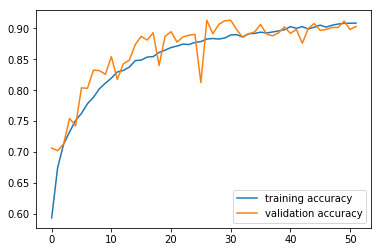

In [24]:
plt.plot(acc_hist, label='training accuracy')
plt.plot(val_hist, label='validation accuracy')
plt.legend()

Wykres wygląda dosyć optymistycznie, myślę, że możemy jeszcze dojechać do okolic 92%, także kontynuuję trening:

In [27]:
history = model.fit(X_train, y_train, epochs=12, validation_data=(X_test, y_test))

Train on 23750 samples, validate on 1250 samples
Epoch 1/12
23750/23750 [==============================] - 747s 31ms/step - loss: 0.2112 - acc: 0.9125 - val_loss: 0.2427 - val_acc: 0.8976
Epoch 2/12
23750/23750 [==============================] - 809s 34ms/step - loss: 0.2196 - acc: 0.9102 - val_loss: 0.2132 - val_acc: 0.9064
Epoch 3/12
23750/23750 [==============================] - 785s 33ms/step - loss: 0.2181 - acc: 0.9114 - val_loss: 0.2164 - val_acc: 0.9104
Epoch 4/12
23750/23750 [==============================] - 742s 31ms/step - loss: 0.2139 - acc: 0.9101 - val_loss: 0.2159 - val_acc: 0.9048
Epoch 5/12
23750/23750 [==============================] - 742s 31ms/step - loss: 0.2117 - acc: 0.9133 - val_loss: 0.2321 - val_acc: 0.9072
Epoch 6/12
23750/23750 [==============================] - 741s 31ms/step - loss: 0.2095 - acc: 0.9128 - val_loss: 0.2253 - val_acc: 0.9088
Epoch 7/12
23750/23750 [==============================] - 741s 31ms/step - loss: 0.2051 - acc: 0.9159 - val_loss: 0.1

Wygląda na to, że osiągamy już poprawność rzędu 90%. Widzimy, że poprawność oraz koszt modelu zaczynają pod koniec już trochę skakać (lekko wzrasta, lekko spada), możemy w związku z tym jeszcze na sam koniec spróbować obniżyć *learning rate* aby wagi były za każdym razem zmieniane delikatniej - to może pomóc w precyzyjnym dostrojeniu modelu.

In [28]:
from keras.optimizers import Adam

In [29]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])

In [30]:
history = model.fit(X_train, y_train, epochs=12, validation_data=(X_test, y_test))

Train on 23750 samples, validate on 1250 samples
Epoch 1/12
23750/23750 [==============================] - 770s 32ms/step - loss: 0.1861 - acc: 0.9241 - val_loss: 0.2075 - val_acc: 0.9136
Epoch 2/12
23750/23750 [==============================] - 766s 32ms/step - loss: 0.1841 - acc: 0.9262 - val_loss: 0.2063 - val_acc: 0.9160
Epoch 3/12
23750/23750 [==============================] - 1111s 47ms/step - loss: 0.1794 - acc: 0.9271 - val_loss: 0.2055 - val_acc: 0.9184
Epoch 4/12
23750/23750 [==============================] - 1123s 47ms/step - loss: 0.1745 - acc: 0.9288 - val_loss: 0.2068 - val_acc: 0.9152
Epoch 5/12
23750/23750 [==============================] - 1067s 45ms/step - loss: 0.1762 - acc: 0.9280 - val_loss: 0.2041 - val_acc: 0.9152
Epoch 6/12
23750/23750 [==============================] - 1059s 45ms/step - loss: 0.1758 - acc: 0.9283 - val_loss: 0.2028 - val_acc: 0.9160
Epoch 7/12
23750/23750 [==============================] - 1062s 45ms/step - loss: 0.1712 - acc: 0.9309 - val_loss

In [31]:
model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['acc'])
history3 = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Train on 23750 samples, validate on 1250 samples
Epoch 1/5
23750/23750 [==============================] - 771s 32ms/step - loss: 0.1662 - acc: 0.9319 - val_loss: 0.2042 - val_acc: 0.9160
Epoch 2/5
23750/23750 [==============================] - 748s 32ms/step - loss: 0.1676 - acc: 0.9309 - val_loss: 0.2043 - val_acc: 0.9176
Epoch 3/5
23750/23750 [==============================] - 1032s 43ms/step - loss: 0.1676 - acc: 0.9317 - val_loss: 0.2060 - val_acc: 0.9160
Epoch 4/5
23750/23750 [==============================] - 1155s 49ms/step - loss: 0.1708 - acc: 0.9309 - val_loss: 0.2037 - val_acc: 0.9152
Epoch 5/5
23750/23750 [==============================] - 7041s 296ms/step - loss: 0.1680 - acc: 0.9311 - val_loss: 0.2058 - val_acc: 0.9144


In [32]:
model.compile(optimizer=Adam(lr=0.000001), loss='binary_crossentropy', metrics=['acc'])
history4 = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))
model.compile(optimizer=Adam(lr=0.0000001), loss='binary_crossentropy', metrics=['acc'])
history5 = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Train on 23750 samples, validate on 1250 samples
Epoch 1/3
23750/23750 [==============================] - 1239s 52ms/step - loss: 0.1705 - acc: 0.9306 - val_loss: 0.2050 - val_acc: 0.9160
Epoch 2/3
23750/23750 [==============================] - 743s 31ms/step - loss: 0.1664 - acc: 0.9328 - val_loss: 0.2044 - val_acc: 0.9160
Epoch 3/3
23750/23750 [==============================] - 781s 33ms/step - loss: 0.1697 - acc: 0.9324 - val_loss: 0.2063 - val_acc: 0.9144
Train on 23750 samples, validate on 1250 samples
Epoch 1/3
23750/23750 [==============================] - 766s 32ms/step - loss: 0.1652 - acc: 0.9323 - val_loss: 0.2053 - val_acc: 0.9160
Epoch 2/3
23750/23750 [==============================] - 759s 32ms/step - loss: 0.1628 - acc: 0.9335 - val_loss: 0.2050 - val_acc: 0.9160
Epoch 3/3
23750/23750 [==============================] - 1747s 74ms/step - loss: 0.1666 - acc: 0.9306 - val_loss: 0.2045 - val_acc: 0.9160


Znów sklejamy historie: pierwsza nadpisana, 12 epok, damy tam puste, następnie mamy `history`, `history3`, `history4` i `history5`.

In [33]:
histories = [history, history3, history4, history5]
acc_hist2, val_hist2 = list(), list()

[acc_hist2.extend(h.history['acc']) for h in histories]
[val_hist2.extend(h.history['val_acc']) for h in histories]

# add 12 NaNs to the front
acc_hist = acc_hist + [np.nan] * 12 + acc_hist2
val_hist = val_hist + [np.nan] * 12 + val_hist2

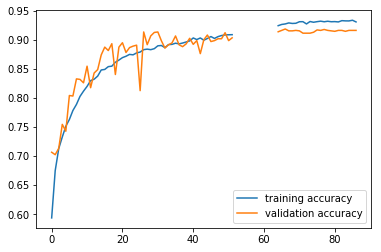

In [34]:
plt.plot(acc_hist, label='training accuracy')
plt.plot(val_hist, label='validation accuracy')
plt.legend()

Wygląda na to, że nie dojedziemy (a przynajmniej w rozsądnym czasie) do wyższej poprawności niz 92%, w związku z tym kończę w tym momencie trening sieci. Sprawdzam poprawność na danych treningowych i testowych.

In [35]:
train_corr = model.evaluate(X_train, y_train)[1]
test_corr = model.evaluate(X_test, y_test)[1]

print('Poprawność na danych treningowych: {:.2f}%'.format(train_corr * 100))
print('Poprawność na danych testowych: {:.2f}%'.format(test_corr * 100))

1250/1250 [==============================] - 3922s 3s/step
Poprawność na danych treningowych: 98.29%
Poprawność na danych testowych: 91.60%


Zauważ że poprawność na danych treningowych jest teraz dużo wyższa niż podczas treningu (98% vs 93%), czy masz pomysł dlaczgo? Podpowiedź nie używamy czegoś, co było używane podczas treningu, a służy do regularyzacji.
Zwróć też uwagę na fakt, że trening trwał bardzo długo (oszacowania czasu po każdej epoce) - bardziej złożona sieć przetważa bodźce wolniej, co w efekcie dla tysięcy bodźców i wielu epok przekałada się na godziny treningu.

## Pytania
Jako że wprowadziłem wiele modyfikacji do oryginalnej sieci z zajęć, trudno jest powiedzieć, która zmiana miała największy wkład we wzrost poprawności. Jest wiele pytań, które można zadać, a na które w sumie nie sposób odpowiedzieć bez poeksperymentowania z siecią:
* więcej filtrów i warstw na pewno pomogło, ale czy potrzebujemy aż `128` filtrów w ostatniej warstwie splotowej?
* regularyzacja na pewno pomogła w walce z *overfittingiem*, szczególnie przy tak dużej liczbie filtrów, ale czy potrzebujemy dropout po każdej (poza pierwszą) warstwie splotowej? Czy wartości droput'u, których używamy (`0.35` oraz `0.5`) są odpowiednie?
* różnica między korzystaniem z aktywacji `relu` a `elu` nie powinna dawać znaczących różnic, ale to warto byłoby przetestować.
* czy wyższa rozdzielczość zdjęć przełożyłaby się na wyższą popraność?
* czy dodając kolejne warstwy splototwe (a rezygnując np. z kilku `MaxPooling`ów) otrzymalibyśmy wyższą poprawność? A może dodając jeszcze jedną warstwę `Dense` przed neuronem klasyfikacyjnym?

Dodatkowo:
* nie stosujemy tzw. *image augmentation* czyli przekształceń zdjęć takich jak przycinanie i obroty, które generalnie nie zmieniają poprawnej klasyfikacji (chyba że pies jest np. na skraju obrazu i przycienając zdjęcie wypadnie nam z kadru), a zwiększają nam różnorodność danych i w efekcie prowadzą do wyższej poprawności. W `Keras` możecie korzystać z `ImageDataGenerator` aby stosować *image augmentation*.

Jeżeli ktoś z Was chce przetestować te pytania / możliwości - jest to świetny motyw na projekt. Mogę Wam udostępnić używany przeze mnie podział na dane treningowe i testowe oraz zapisaną sieć, abyście mogli porównać wyniki swojego podejścia oraz sieci testowanej w tym notebook'u.

## Analiza błędów
Na koniec jeszcze tylko analiza błędów popełnianych przez sieć na danych testowych.

In [36]:
predictions = model.predict(X_test)
if_correct = np.round(predictions).ravel() == y_test

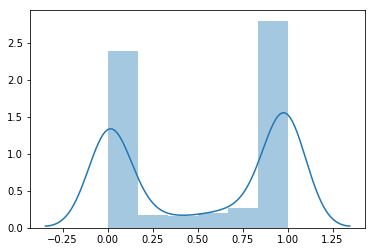

In [38]:
import seaborn as sns

sns.distplot(predictions)

Rozkład przewidywań jest silnie spolaryzowany - w większości sytuacji sieć jest pewna czy ma do czynienia z psem czy kotem. Interesują nas błędy oraz przypadki niskiej pewności: ciekawe są np. sytuacje błędów z wysoką vs niską pewnością oraz poprawnych odpowiedzi z niską pewnością.

In [45]:
incorrect_predictions = np.where(if_correct == 0)[0]
incorrect_predictions[:6]

array([ 0,  6, 10, 19, 26, 40], dtype=int64)

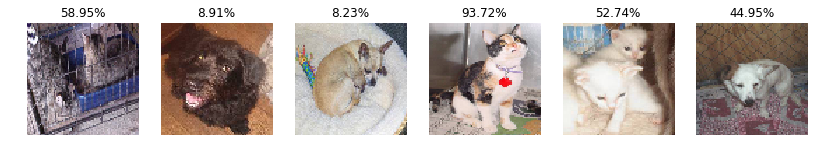

In [48]:
fig, ax = plt.subplots(ncols=6, figsize=(14, 5))

for idx in range(6):
    img_idx = incorrect_predictions[idx]
    ax[idx].imshow(X_test[img_idx])
    ax[idx].set_title('{:.2f}%'.format(predictions[img_idx, 0] * 100))
    ax[idx].axis('off')

Analiza błędów popełnianych przez sieć zwykle daje ciekawy wgląd w funkcjonowanie sieci, a szczególnie ograniczenia obecnie stosowanych rozwiązań w porównaniu do percepcji człowieka. Pierwsze z powyższych zdjęć faktycznie jest nieco nietypowe i w efecie sieć nie ma pewności, możliwe że np. obecność krat lekko przechyla pewność powyżej 50% (a więc na psią stronę mocy). Drugie zdjęcie jest o tyle ciekawe, że sieć wykazuje dużą pewność, że obraz przedstawia kota (100 - 8.9 tzn. 91.1% że jest obecny kot). Perspektywa w tym zdjęciu jest nieco inna, korpus psa nie jest dobrze widoczny, ponadto może w danych treningowych nie było wiele ciemnych psów? Trzecie zdjęcie to piesek zwinięty w kłębek, co może mylić sieć wraz z obecnością szpiczastych uszu. Czwarte zdjęcie - duża pewność, że na zdjęciu jest pies, faktycznie, kot na tym zdjęciu ma nieco psią posturę. Na piątym zdjęciu koci osesek z przodu, o pochylonej głowie, może pchać sieć nieco w stronę psa, a kształt z tyłu w stronę kota, w efekcie mamy prawie remis (52.7%). Ostatnie zdjęcie również można zinterpretować jako nieco nietypową postawę dla psa. Sieć w każdym razie ewidentnie nie umie ze zdjęcia wnioskować o długości pyszczka - wtedy prawie wszystkie powyższe przykłady rozwiązałaby bez problemu.

In [49]:
len(incorrect_predictions)

105

Mamy `105` błędów, więc w zasadzie możemy wyświetlić je wszystkie.
Poniżej przedstawiamy wszystkie błędy sieci na danych testowych, macie jakieś ciekawe interpretacje? Szczególnie zaskakuje zdjęcie w drugim wierszu, pierwszej kolumnie - jak można nie złapać tego, że to kot (sieć ma ponad 99% pewności że to pies)?  

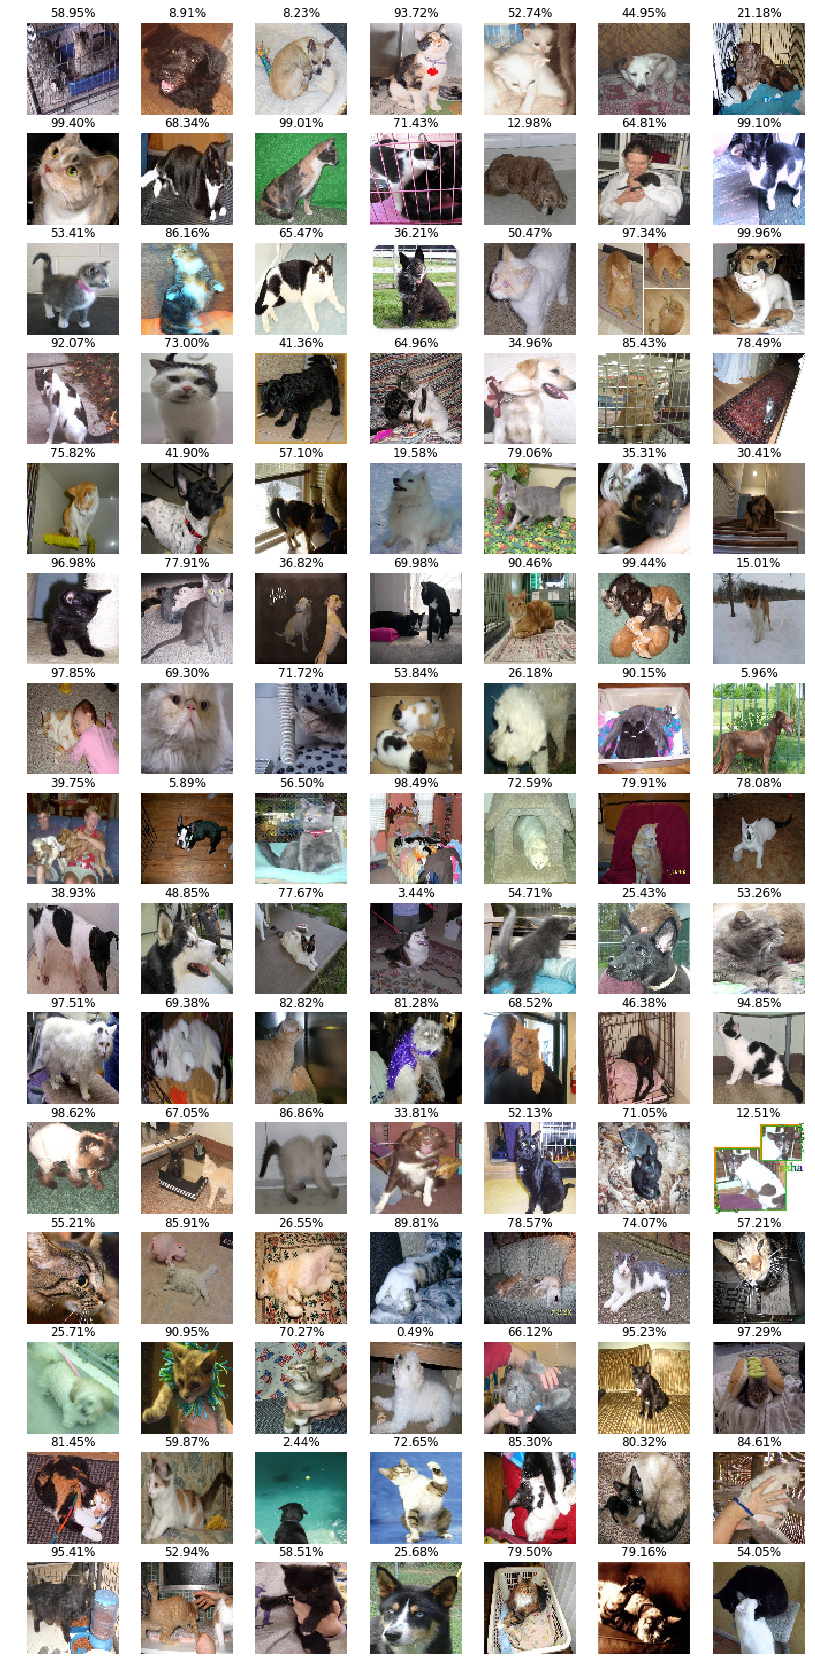

In [52]:
fig, ax = plt.subplots(ncols=7, nrows=15, figsize=(14, 30))
ax = ax.ravel()

for idx in range(len(incorrect_predictions)):
    img_idx = incorrect_predictions[idx]
    ax[idx].imshow(X_test[img_idx])
    ax[idx].set_title('{:.2f}%'.format(predictions[img_idx, 0] * 100))
    ax[idx].axis('off')

Zobaczmy jeszcze na koniec trochę poprawnych predykcji z wysoką i niską pewnością. Najpierw wysoka pewność:

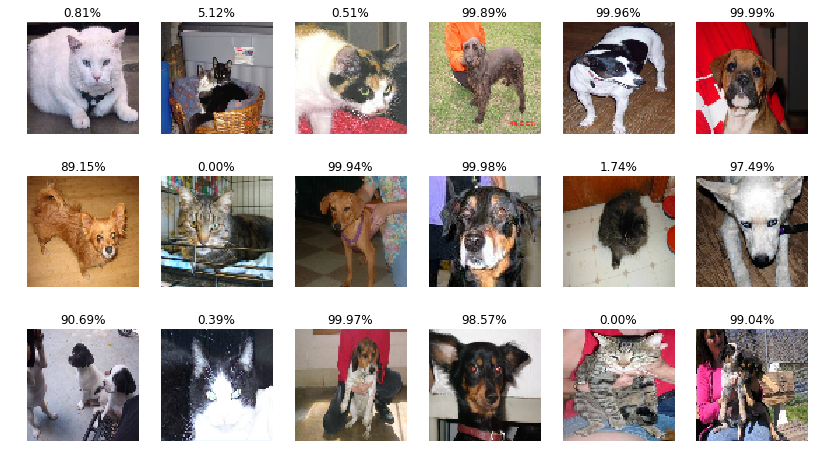

In [59]:
# znajdujemy poprawne przewidywania oraz obliczamy pewność
confidence = np.abs(predictions.ravel() - 0.5) * 2
correct_predictions = np.where(if_correct)[0]
confidence_for_correct_predictions = confidence[correct_predictions]

# znajdujemy poprawne przedidywania z wysoką pewnością
high_confidence = np.where(confidence_for_correct_predictions > 0.75)[0]
correct_high_confidence = correct_predictions[high_confidence]

# wyświetlamy
fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(14, 8))
ax = ax.ravel()

for idx in range(3 * 6):
    img_idx = correct_high_confidence[idx]
    ax[idx].imshow(X_test[img_idx])
    ax[idx].set_title('{:.2f}%'.format(predictions[img_idx, 0] * 100))
    ax[idx].axis('off')

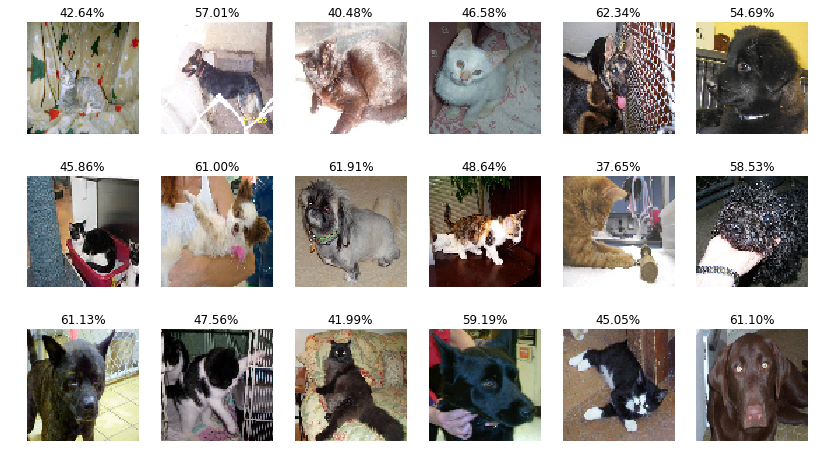

In [58]:
# znajdujemy poprawne przewidywania o niskiej pewności
low_confidence = np.where(confidence_for_correct_predictions < 0.25)[0]
correct_low_confidence = correct_predictions[low_confidence]

# wyświetlamy
fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(14, 8))
ax = ax.ravel()

for idx in range(3 * 6):
    img_idx = correct_low_confidence[idx]
    ax[idx].imshow(X_test[img_idx])
    ax[idx].set_title('{:.2f}%'.format(predictions[img_idx, 0] * 100))
    ax[idx].axis('off')

Ważne jest aby pamiętać, że przez to, że sieci uczą się z gotowych zdjęć, a nie z interakcji z trójwymiarowym światem, znacząco różnią się w "percepcji" takich zdjęć od ludzi. Mają np. dużo mniejsze zrozumienie dla perspektywy, a więc jeżeli w danych treningowych jest mało psów/kotów widzianych z profilu - nie nauczą się dobrze rozpoznawać tego rodzaju bodźców.

In [60]:
model.save('model_80_80_final')